<h1 style = "text-align:center"> RCIDS_ML_BOT </h1>
<img src = "https://static.latribune.fr/resource_page_big/708337/chatbot-by-synapse.jpg" />


**RCIDS_ML_BOT est un moteur de recherche intelligent des connaissances disponibles dans une base des connaissances locales.**

**Il a pour but de répondre aux questions de machine Learning qui lui seront posées par des étudiants.** 

In [1]:
#Importation des bibliothèques
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from underthesea import word_tokenize 
from keras import Input, Model
from keras.layers import Embedding, LSTM, Dense
from keras_preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('datachat.csv')
df.head()

,Unnamed: 0,level_0,Question,Answer,Tags
0,0,0,How does boosting work?,In plain English: If your classifier misclassi...,"['machine-learning', 'boosting']"
1,1,1,How does random forest generate the random forest,Implementations of RF differ slightly. I know ...,"['machine-learning', 'r', 'algorithms', 'cart'..."
2,2,2,What are the differences between the Baum-Welc...,The Baum-Welch algorithm and the Viterbi algor...,"['machine-learning', 'hidden-markov-model', 'i..."
3,3,3,What is the 'fundamental' idea of machine lear...,If statistics is all about maximizing likeliho...,"['machine-learning', 'maximum-likelihood', 'lo..."
4,4,4,What is the weak side of decision trees?,Here are a couple I can think of:\n\nThey can ...,"['machine-learning', 'nonparametric', 'cart']"


In [3]:
#Supprimons les colones Unnamed: 0 et level_0
df=df.drop(['Unnamed: 0', 'level_0'],axis=1)
df.head()

,Question,Answer,Tags
0,How does boosting work?,In plain English: If your classifier misclassi...,"['machine-learning', 'boosting']"
1,How does random forest generate the random forest,Implementations of RF differ slightly. I know ...,"['machine-learning', 'r', 'algorithms', 'cart'..."
2,What are the differences between the Baum-Welc...,The Baum-Welch algorithm and the Viterbi algor...,"['machine-learning', 'hidden-markov-model', 'i..."
3,What is the 'fundamental' idea of machine lear...,If statistics is all about maximizing likeliho...,"['machine-learning', 'maximum-likelihood', 'lo..."
4,What is the weak side of decision trees?,Here are a couple I can think of:\n\nThey can ...,"['machine-learning', 'nonparametric', 'cart']"


In [4]:
df.shape

(5260, 3)

In [5]:
# Determination des valeurs manquantes
null=pd.DataFrame(df.isnull().sum(),columns=['Null Values'])
null['%']=(df.isna().sum()/len(df)*100)
null = null[null['%'] > 0]
null.style.background_gradient(cmap='viridis',low =0.2,high=0.1)

,Null Values,%
Tags,831,15.798479


**Il existe 831 valeurs manquantes dans la variable Tags**

La valeurs Tags ne nous interresse pas vraiment dans la réalisation de notre projet. car il sagira de réaliser un **générative chatbot** et non un **rétrivial base chatbot**

Cependant nous allons diminuer le nombre de nos données, afin d'éviter certain problemes.

In [6]:
#df. to_excel ( "chatbot.xlsx" )

In [7]:
# Importons la nouvelle base de donnée reduite
data = pd.read_excel('chatbot.xlsx')
data.head()

,Unnamed: 0,Question,Answer,Tags
0,0,How does boosting work?,In plain English: If your classifier misclassi...,"['machine-learning', 'boosting']"
1,1,How does random forest generate the random forest,Implementations of RF differ slightly. I know ...,"['machine-learning', 'r', 'algorithms', 'cart'..."
2,2,What are the differences between the Baum-Welc...,The Baum-Welch algorithm and the Viterbi algor...,"['machine-learning', 'hidden-markov-model', 'i..."
3,3,What is the 'fundamental' idea of machine lear...,If statistics is all about maximizing likeliho...,"['machine-learning', 'maximum-likelihood', 'lo..."
4,4,What is the weak side of decision trees?,Here are a couple I can think of:\n\nThey can ...,"['machine-learning', 'nonparametric', 'cart']"


In [8]:
data.shape

(11, 4)

In [9]:
# Supprimons les variables 'Unnamed: 0' et 'Tags'
data=data.drop(['Unnamed: 0', 'Tags'],axis=1)
data

,Question,Answer
0,How does boosting work?,In plain English: If your classifier misclassi...
1,How does random forest generate the random forest,Implementations of RF differ slightly. I know ...
2,What are the differences between the Baum-Welc...,The Baum-Welch algorithm and the Viterbi algor...
3,What is the 'fundamental' idea of machine lear...,If statistics is all about maximizing likeliho...
4,What is the weak side of decision trees?,Here are a couple I can think of:\n\nThey can ...
5,"For data similar to audio, how to determine if...",To answer this question it needs to be clear a...
6,"Feature selection for ""final"" model when perfo...","Whether you use LOO or K-fold CV, you'll end u..."
7,Why does the random forest OOB estimate of err...,This is feature selection overfit and this is ...
8,"What is an ""If-Then"" rule?",It is just a simple classifier; so simple that...
9,How to assess overfitting?,This result does not mean that you have overfi...


In [10]:
a = pd.Series(data.columns)

In [11]:
a = a.rename({0: data.Question,1: data.Answer})

In [12]:
b = {'Question':'Hi','Answer':'hello'}

In [13]:
c = {'Question':'Hello','Answer':'hi'}

In [14]:
d= {'Question':'how are you','Answer':"i'm fine. how about yourself?"}

In [15]:
e= {'Question':'how are you doing','Answer':"i'm fine. how about yourself?"}

In [16]:
f= {'Question':'How were you designed or manufactured','Answer':"I was conceived thanks to Mrs NAJIMA DAOUDI and Mrs EL AZHARI KHADIJA, during the internship PFE of the student KONE YANOGAH JULES"}

In [17]:
g= {'Question':'what is your name','Answer':"my name is RCIDS_ML_BOT"}

In [18]:
h= {'Question':'how old are you','Answer':"I have less than a week"}

In [19]:
i= {'Question':'In which country are the people who designed you','Answer':"the people who conceived me, come from Morocco and France"}

In [20]:
data.columns=['Question','Answer']

In [21]:
data = data.append([b,c,d,e,f,g,h,i],ignore_index=True)

In [22]:
data

,Question,Answer
0,How does boosting work?,In plain English: If your classifier misclassi...
1,How does random forest generate the random forest,Implementations of RF differ slightly. I know ...
2,What are the differences between the Baum-Welc...,The Baum-Welch algorithm and the Viterbi algor...
3,What is the 'fundamental' idea of machine lear...,If statistics is all about maximizing likeliho...
4,What is the weak side of decision trees?,Here are a couple I can think of:\n\nThey can ...
5,"For data similar to audio, how to determine if...",To answer this question it needs to be clear a...
6,"Feature selection for ""final"" model when perfo...","Whether you use LOO or K-fold CV, you'll end u..."
7,Why does the random forest OOB estimate of err...,This is feature selection overfit and this is ...
8,"What is an ""If-Then"" rule?",It is just a simple classifier; so simple that...
9,How to assess overfitting?,This result does not mean that you have overfi...


In [23]:
# juste pour mélanger aléatoirement les lignes de ma base de données
data = data.sample(frac=1)
data

,Question,Answer
1,How does random forest generate the random forest,Implementations of RF differ slightly. I know ...
15,How were you designed or manufactured,I was conceived thanks to Mrs NAJIMA DAOUDI an...
14,how are you doing,i'm fine. how about yourself?
16,what is your name,my name is RCIDS_ML_BOT
13,how are you,i'm fine. how about yourself?
11,Hi,hello
6,"Feature selection for ""final"" model when perfo...","Whether you use LOO or K-fold CV, you'll end u..."
10,What is behind Google Prediction API?,Google is using different machine learning tec...
3,What is the 'fundamental' idea of machine lear...,If statistics is all about maximizing likeliho...
8,"What is an ""If-Then"" rule?",It is just a simple classifier; so simple that...


In [24]:
# Cette commande consiste à transformer les phrases de la colone Question en minuscule, et à supprimer les ponctuactions
#import string
#data['Question'] = data['Question'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
#data['Question'] = data['Question'].apply(lambda wrd: ''.join(wrd))
#data.head()

In [25]:
# Cette commande consiste à transformer les phrases de la colone Answer en minuscule, et à supprimer les ponctuactions 
#import string
#data['Answer'] = data['Answer'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
#data['Answer'] = data['Answer'].apply(lambda wrd: ''.join(wrd))
#data.head()

In [26]:
# renvoie un tableau numpy avec les données sous-jacentes du DataFrame, sans index ni noms de colonnes.
data_questions = data['Question'].values
data_answers = data['Answer'].values

In [27]:
data_questions

array(['How does random forest generate the random forest',
       'How were you designed or manufactured', 'how are you doing',
       'what is your name', 'how are you', 'Hi',
       'Feature selection for "final" model when performing cross-validation in machine learning',
       'What is behind Google Prediction API?',
       "What is the 'fundamental' idea of machine learning for estimating parameters?",
       'What is an "If-Then" rule?',
       'What is the weak side of decision trees?',
       'How does boosting work?', 'how old are you',
       'How to assess overfitting?',
       'In which country are the people who designed you', 'Hello',
       'Why does the random forest OOB estimate of error improve when the number of features selected are decreased?',
       'What are the differences between the Baum-Welch algorithm and Viterbi training?',
       'For data similar to audio, how to determine if there are 1 or 2 categories?'],
      dtype=object)

In [28]:
data_answers

array(["Implementations of RF differ slightly. I know that Salford Systems' proprietary implementation is supposed to be better than the vanilla one in R. A description of the algorithm is in ESL by Friedman-Hastie-Tibshirani, 2nd ed, 3rd printing. An entire chapter (15th) is devoted to RF, and I find it actually clearer than the original paper. The tree construction algorithm is detailed on p.588; no need for me to reproduce it here, since the book is available online.\n",
       'I was conceived thanks to Mrs NAJIMA DAOUDI and Mrs EL AZHARI KHADIJA, during the internship PFE of the student KONE YANOGAH JULES',
       "i'm fine. how about yourself?", 'my name is RCIDS_ML_BOT',
       "i'm fine. how about yourself?", 'hello',
       "Whether you use LOO or K-fold CV, you'll end up with different features since the cross-validation iteration must be the most outer loop, as you said. You can think of some kind of voting scheme which would rate the n-vectors of features you got from your 

In [29]:
# Fonction pour supprimer les impuretés dans les textes
def clean_text(sent):
    return re.sub(r'[!“”"#$%&\'()*+,-/:;<=>?@[\]^`{|}~]', '', sent)

# fonction pour convertir la segmentation de mots
def clean_and_word_segmentation(sent):
    return word_tokenize(clean_text(sent.lower()), format='text')

In [30]:
# Consiste à compter la longueur des questions nettoyées, et mettre tout ceci dans une liste de mots et de phrases
count_words_ques = [len(clean_text(ques).split()) for ques in data_questions]
# Counter permet de compter le nombre d'éléments de chaque type (la clef est l'élément et la valeur le nombre)
counter_words_ques = Counter(count_words_ques)

list_count_word = []
list_count_sent = []
#La items()méthode renvoie un objet de vue qui affiche une liste de paires de tuples (clé, valeur) du dictionnaire.
for i in counter_words_ques.items():
    list_count_word.append(i[0])
    list_count_sent.append(i[1])
#print(i)

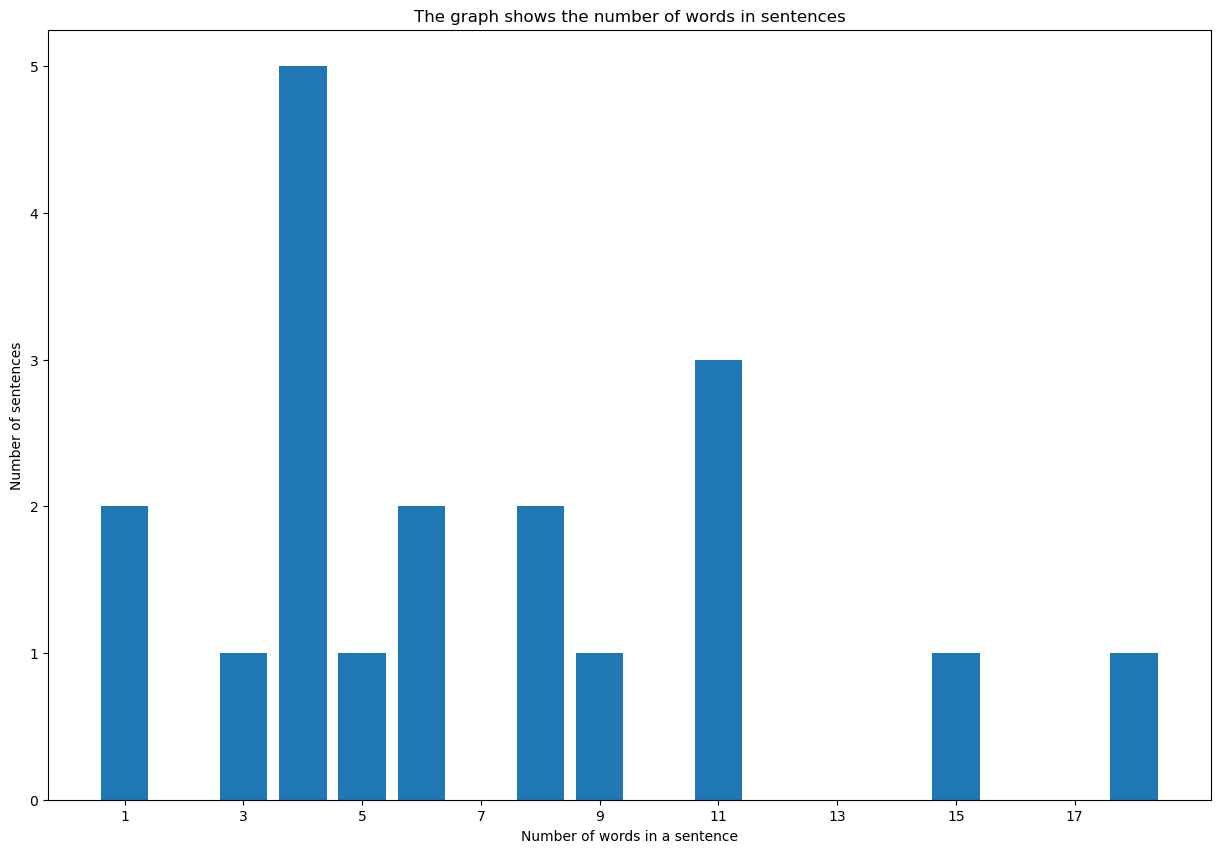

In [31]:
# dessinons un graphique pour représenter visuellement le nombre de mots dans les questions
plt.figure(figsize=(15,10))
plt.bar(list_count_word,list_count_sent)
plt.title('The graph shows the number of words in sentences')
plt.xlabel('Number of words in a sentence')
plt.ylabel('Number of sentences')
plt.xticks(range(min(list_count_word), max(list_count_word),2))
plt.show()

In [32]:
# La longueur des questions nettoyées, et la longueur des questions elles memes.
len(count_words_ques), len(data_questions)

(19, 19)

In [33]:
#L'une des limites du cadre seq2seq est que toutes les informations de la phrase d'entrée doivent être codées dans un vecteur de longueur fixe, context . Au fur et à mesure que la longueur de la séquence augmente, nous commençons à perdre une quantité considérable d'informations. C'est pourquoi le modèle de base seq2seq ne fonctionne pas bien pour décoder de grandes séquences.
#Il est difficile pour les modèles de composer avec de longues phrases.
#supprimer les phrases avec un nombre de mots > 20 mots
sorted_ques = []
sorted_ans = []
for i,count in enumerate(count_words_ques):
    if count <= 20:
        sorted_ques.append(data_questions[i])
        sorted_ans.append(data_answers[i])
        
print('len sorted_ques:', len(sorted_ques))
print('len sorted_ans:', len(sorted_ans))
sorted_ques[:2], sorted_ans[:2]

len sorted_ques: 19
len sorted_ans: 19


(['How does random forest generate the random forest',
  'How were you designed or manufactured'],
 ["Implementations of RF differ slightly. I know that Salford Systems' proprietary implementation is supposed to be better than the vanilla one in R. A description of the algorithm is in ESL by Friedman-Hastie-Tibshirani, 2nd ed, 3rd printing. An entire chapter (15th) is devoted to RF, and I find it actually clearer than the original paper. The tree construction algorithm is detailed on p.588; no need for me to reproduce it here, since the book is available online.\n",
  'I was conceived thanks to Mrs NAJIMA DAOUDI and Mrs EL AZHARI KHADIJA, during the internship PFE of the student KONE YANOGAH JULES'])

In [34]:
# Nettoyage et segmentation de mots pour sorted_ques et sorted_ans
questions = [clean_and_word_segmentation(ques) for ques in sorted_ques]
answers = ['<START> '+ clean_and_word_segmentation(answ) + ' <END>' for answ in sorted_ans]

questions[:2], answers[:2]

(['how does random forest generate the random forest',
  'how were you designed or manufactured'],
 ['<START> implementations of rf differ slightly i know that salford systems proprietary implementation is supposed to be better than the vanilla one in r a description of the algorithm is in esl by friedmanhastietibshirani 2 nd ed 3 rd printing an entire chapter 15 th is devoted to rf and i find it actually clearer than the original paper the tree construction algorithm is detailed on p588 no need for me to reproduce it here since the book is available online <END>',
  '<START> i was conceived thanks to mrs najima daoudi and mrs el azhari khadija during the internship pfe of the student kone yanogah jules <END>'])

In [35]:
# tokeniser les questions et réponses
# filtres='', Car les données ont été nettoyées et la segmentation du mot est conservée
tokenizer = Tokenizer(filters='', lower=False)  
tokenizer.fit_on_texts(questions + answers)

In [36]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f'Vocabulary size : {VOCAB_SIZE}')

Vocabulary size : 800


In [37]:
# Encodeur

# Le vecteur de contexte est un goulot d’étranglement pour les modèles avec beaucoup de mots.
tokenized_questions = tokenizer.texts_to_sequences(questions)
maxlen_questions = 20
# pad_sequence empile une liste de Tensors le long d'une nouvelle dimension et les remplit à une longueur égale(rembourage)
encoder_inp = pad_sequences(tokenized_questions,maxlen=maxlen_questions,padding='post')

print(encoder_inp.shape)
print(questions[0])
print(tokenized_questions[0])
print(encoder_inp[0])

(19, 20)
how does random forest generate the random forest
[31, 84, 39, 70, 269, 1, 39, 70]
[ 31  84  39  70 269   1  39  70   0   0   0   0   0   0   0   0   0   0
   0   0]


In [38]:
# Decodeur
tokenized_answers = tokenizer.texts_to_sequences(answers)
maxlen_answers = np.max([len(x) for x in tokenized_answers])
decoder_inp = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')

print(decoder_inp.shape)
print(answers[0])
print(tokenized_answers[0])
print(decoder_inp[0])

(19, 384)
<START> implementations of rf differ slightly i know that salford systems proprietary implementation is supposed to be better than the vanilla one in r a description of the algorithm is in esl by friedmanhastietibshirani 2 nd ed 3 rd printing an entire chapter 15 th is devoted to rf and i find it actually clearer than the original paper the tree construction algorithm is detailed on p588 no need for me to reproduce it here since the book is available online <END>
[13, 295, 2, 53, 296, 170, 46, 73, 14, 297, 298, 299, 300, 3, 301, 4, 12, 74, 63, 1, 302, 90, 7, 75, 8, 303, 2, 1, 11, 3, 7, 304, 32, 305, 89, 306, 307, 121, 308, 309, 28, 310, 122, 311, 312, 3, 313, 4, 53, 5, 46, 123, 15, 314, 315, 63, 1, 316, 171, 1, 91, 317, 11, 3, 318, 29, 319, 124, 320, 10, 125, 4, 321, 15, 126, 76, 1, 322, 3, 323, 324, 16]
[ 13 295   2  53 296 170  46  73  14 297 298 299 300   3 301   4  12  74
  63   1 302  90   7  75   8 303   2   1  11   3   7 304  32 305  89 306
 307 121 308 309  28 310 122

In [39]:
for i in range(len(tokenized_answers)):
    tokenized_answers[i] = tokenized_answers[i][1:]
    
padded_answers = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')
decoder_final_output = to_categorical(padded_answers, VOCAB_SIZE)

print(decoder_final_output.shape)
print(tokenized_answers[0])
print(padded_answers[0])
print(decoder_final_output[0])

(19, 384, 800)
[295, 2, 53, 296, 170, 46, 73, 14, 297, 298, 299, 300, 3, 301, 4, 12, 74, 63, 1, 302, 90, 7, 75, 8, 303, 2, 1, 11, 3, 7, 304, 32, 305, 89, 306, 307, 121, 308, 309, 28, 310, 122, 311, 312, 3, 313, 4, 53, 5, 46, 123, 15, 314, 315, 63, 1, 316, 171, 1, 91, 317, 11, 3, 318, 29, 319, 124, 320, 10, 125, 4, 321, 15, 126, 76, 1, 322, 3, 323, 324, 16]
[295   2  53 296 170  46  73  14 297 298 299 300   3 301   4  12  74  63
   1 302  90   7  75   8 303   2   1  11   3   7 304  32 305  89 306 307
 121 308 309  28 310 122 311 312   3 313   4  53   5  46 123  15 314 315
  63   1 316 171   1  91 317  11   3 318  29 319 124 320  10 125   4 321
  15 126  76   1 322   3 323 324  16   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

In [40]:
# Nous devons transformer les mots d’entrée en vecteurs avant de les traiter. Cette transformation se fait à l’aide d’un algorithme de word embedding
enc_inputs = Input(shape=(None,))
enc_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(enc_inputs)
_, state_h, state_c = LSTM(200, return_state=True)(enc_embedding)
enc_states = [state_h, state_c]

dec_inputs = Input(shape=(None,))
dec_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(dec_inputs)
dec_lstm = LSTM(200, return_state=True, return_sequences=True)
# La non linéarité est tres importante dans les reseaux de neurones. Sans la fonction d'activation, un reseau de neurone devient simplement linéaire.
dec_outputs, _, _ = dec_lstm(dec_embedding, initial_state=enc_states)
dec_dense = Dense(VOCAB_SIZE, activation='softmax')
output = dec_dense(dec_outputs)

In [41]:
model = Model([enc_inputs, dec_inputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    160000      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    160000      ['input_2[0][0]']                
                                                                                              

In [42]:
#Decomposons les données en données d'entrainements et de tests
decoder_inp_train, decoder_inp_test, encoder_inp_train, encoder_inp_test = train_test_split(decoder_inp,encoder_inp, test_size = 0.20, random_state = 42)

In [43]:
print(decoder_inp_train.shape)
print(encoder_inp_train.shape)

(15, 384)
(15, 20)


In [44]:
print(decoder_inp_test.shape)
print(encoder_inp_test.shape)

(4, 384)
(4, 20)


In [45]:
# Entrainons le model
model.fit([encoder_inp, decoder_inp],
           decoder_final_output,
           batch_size=100,
           epochs=1000)
model.save('sequence2sequence_lstm.h5')

Epoch 1/1000
1/1 [==============================] - 8s 8s/step - loss: 1.9231
Epoch 2/1000
1/1 [==============================] - 1s 716ms/step - loss: 1.9195
Epoch 3/1000
1/1 [==============================] - 1s 795ms/step - loss: 1.9121
Epoch 4/1000
1/1 [==============================] - 1s 720ms/step - loss: 1.8082
Epoch 5/1000
1/1 [==============================] - 1s 642ms/step - loss: 1.7157
Epoch 6/1000
1/1 [==============================] - 1s 620ms/step - loss: 1.6832
Epoch 7/1000
1/1 [==============================] - 1s 870ms/step - loss: 1.6717
Epoch 8/1000
1/1 [==============================] - 1s 655ms/step - loss: 1.6676
Epoch 9/1000
1/1 [==============================] - 1s 753ms/step - loss: 1.6657
Epoch 10/1000
1/1 [==============================] - 1s 728ms/step - loss: 1.6644
Epoch 11/1000
1/1 [==============================] - 1s 765ms/step - loss: 1.6633
Epoch 12/1000
1/1 [==============================] - 1s 766ms/step - loss: 1.6619
Epoch 13/1000
1/1 [=========

In [46]:
def make_inference_models():
    dec_state_input_h = Input(shape=(200,))
    dec_state_input_c = Input(shape=(200,))
    dec_states_inputs = [dec_state_input_h, dec_state_input_c]
    dec_outputs, state_h, state_c = dec_lstm(dec_embedding,
                                            initial_state=dec_states_inputs)
    dec_states = [state_h, state_c]
    dec_outputs = dec_dense(dec_outputs)
    dec_model = Model(
        inputs=[dec_inputs] + dec_states_inputs,
        outputs = [dec_outputs] + dec_states)
    print('Inference decoder:')
    dec_model.summary()
    print('Inference encoder:')
    enc_model = Model(inputs=enc_inputs, outputs=enc_states)
    enc_model.summary()
    return enc_model, dec_model

def str_to_tokens(sentence):
    #words = sentence.lower().split()
    words = clean_and_word_segmentation(sentence).split()
    tokens_list = list()
    for current_word in words:
        result = tokenizer.word_index.get(current_word)
        if result != '':
            tokens_list.append(result)
    return pad_sequences([tokens_list], maxlen=maxlen_questions,padding='post')

enc_model, dec_model = make_inference_models()

Inference decoder:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    160000      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 200)]        0           []                               
                                                                         

In [49]:
def chatbot():
    print('RCIDS_ML_BOT: Hi, I am RCIDS_ML_BOT and I will make the effort to answer your different Machine Learning questions !')
    
    while True:
        input_question = input('Question: ')
    
        if input_question == 'bye':
            print('RCIDS_ML_BOT answer: bye')
            break
        states_values = enc_model.predict(str_to_tokens(input_question))
        empty_target_seq = np.zeros((1,1))
        empty_target_seq[0,0] = tokenizer.word_index['<START>']
        stop_condition = False
        decoded_translation = ''
        while not stop_condition:
            dec_outputs, h, c = dec_model.predict([empty_target_seq]+states_values)
            sampled_word_index = np.argmax(dec_outputs[0,-1, :])
            sampled_word = None
            for word, index in tokenizer.word_index.items():
                if sampled_word_index == index:
                    if word != '<END>':
                        decoded_translation += f'{word} '
                    sampled_word = word

            if sampled_word == '<END>' or len(decoded_translation.split()) > maxlen_answers:
                stop_condition = True
            empty_target_seq = np.zeros((1,1))
            empty_target_seq[0,0] = sampled_word_index
            states_values = [h,c]

        print('Bot answer:', decoded_translation, '\n')

In [ ]:
# Nous pouvons commencer à poser nos différentes questions
chatbot()

RCIDS_ML_BOT: Hi, I am RCIDS_ML_BOT and I will make the effort to answer your different Machine Learning questions !
Question: hello
Bot answer: hi  

Question: hi
Bot answer: hello  

Question: how are you
Bot answer: im fine how about yourself  

Question: what is your name
Bot answer: my name is rcids_ml_bot  

Question: how old are you
Bot answer: i have less than a week  

Question: How were you designed or manufactured
Bot answer: i was conceived thanks to mrs najima daoudi and mrs el azhari khadija during the internship pfe of the student kone yanogah jules  

Question: How does boosting work
Bot answer: in plain english if your classifier misclassifies some data train another copy of it mainly on this misclassified part with hope that it will discover something subtle and then as usual iterate on the way there are some voting schemes that allow to combine all those classifiers predictions in sensible way because sometimes it is impossible the noise is just hiding some of the in